In [1]:
import gc

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import clip

from ipywidgets import interact, widgets
from tqdm import tqdm

from PIL import Image
from skimage.io import imread_collection
from skimage.util import img_as_ubyte
from skimage.transform import AffineTransform, warp

In [2]:
torch.set_grad_enabled(False)

In [3]:
images = [*(pictures := imread_collection("./house_adversarial.ignore/*.png"))]

shift_y, shift_x = np.array(pictures[0].shape[:2]) / 2.
tf_rotate = AffineTransform(rotation=np.deg2rad(90))
tf_shear = AffineTransform(shear=(0.15, 0.15))
tf_shift = AffineTransform(translation=[-shift_x, -shift_y])
tf_shift_inv = AffineTransform(translation=[shift_x, shift_y])

images.extend([img_as_ubyte(warp(picture, (tf_shift + (tf_rotate + tf_shift_inv)).inverse, cval=1.)) for picture in pictures])
images.extend([img_as_ubyte(warp(picture, (tf_shift + (tf_rotate + tf_rotate + tf_shift_inv)).inverse, cval=1.)) for picture in pictures])
images.extend([img_as_ubyte(warp(picture, (tf_shift + (tf_rotate + tf_rotate + tf_rotate + tf_shift_inv)).inverse, cval=1.)) for picture in pictures])
images.extend([img_as_ubyte(warp(picture, tf_shear, cval=1.)) for picture in pictures])

operations = ['original', '90', '180', '270', 'shear']

In [4]:
categories = ["house", "bird", "fish", "tree", "cat", "dog", "horse", "rabbit", "goat", "shirt", "chair"]  # , "boat"]
prefixes = [
    ["", "A", "An", "An abstract"],
    ["", "A Tangram representation of", "A Tangram puzzle of", "A geometric depiction of", "A Tangram-inspired", "A Tangram-like"]
]
suffixes = [
    ["", "made of tangrams", "formed from tangrams", "consisting of tangrams", "assembled from tangrams", "created with tangrams"],
    ["", "pattern", "configuration", "shape", "arrangement", "composition"]
]

negative_prefixes = [
    ["Not", "Not a", "Not an", "Not an abstract"],
    ["Not", "Not a Tangram representation of", "Not a Tangram puzzle of", "Not a geometric depiction of", "Not a Tangram-inspired", "Not a Tangram-like"]
]

In [5]:
model, preprocess = clip.load("ViT-L/14", device='cuda')
model_temperature = 1.  # do a search over as a hyperparameter
model.eval();

In [6]:
image_features = model.encode_image(torch.cat([preprocess(Image.fromarray(image)).to('cuda') for image in images]).view(-1, 3, 224, 224))
image_features /= image_features.norm(dim=-1, keepdim=True)

In [7]:
baseline_features = image_features[len(pictures) - 1]

In [8]:
# def plot_target_similarity(i):
#     plt.plot((model.logit_scale.exp() * image_features @ image_features[0] / i).softmax(dim=-1).cpu().numpy())

# interact(plot_target_similarity, i=widgets.IntSlider(value=50, min=1));

In [9]:
import string
import random
get_random_string = lambda length: random.choice(string.ascii_lowercase) + ''.join(random.choice(string.ascii_lowercase + ' ' * 2) for _ in range(length - 1))

In [10]:
alpha = 0
beta = 1.

In [11]:
text_features_list = []
ps_list = []
for post_suffix in ['', 'uiih rfvfgbblae ghwyrfyegf', None]:
    for prefixs, suffixs, neg_prefixs in zip(prefixes, suffixes, negative_prefixes):
        for prefix, neg_prefix in zip(prefixs, neg_prefixs):
            for suffix in suffixs:
                ps = post_suffix if post_suffix is not None else get_random_string(20)
                labels = [f'{prefix} {label} {suffix} {ps}' for label in categories]
                ps_list.append((prefix, neg_prefix, suffix, ps))

                text_features = model.encode_text(clip.tokenize(labels).to('cuda'))
                text_features /= text_features.norm(dim=-1, keepdim=True)

                neg_labels = [f'{neg_prefix} {label} {suffix} {ps}' for label in categories]
                neg_text_features = model.encode_text(clip.tokenize(neg_labels).to('cuda'))
                neg_text_features /= text_features.norm(dim=-1, keepdim=True)

                text_features_list.append(text_features - alpha * neg_text_features)

<AxesSubplot: >

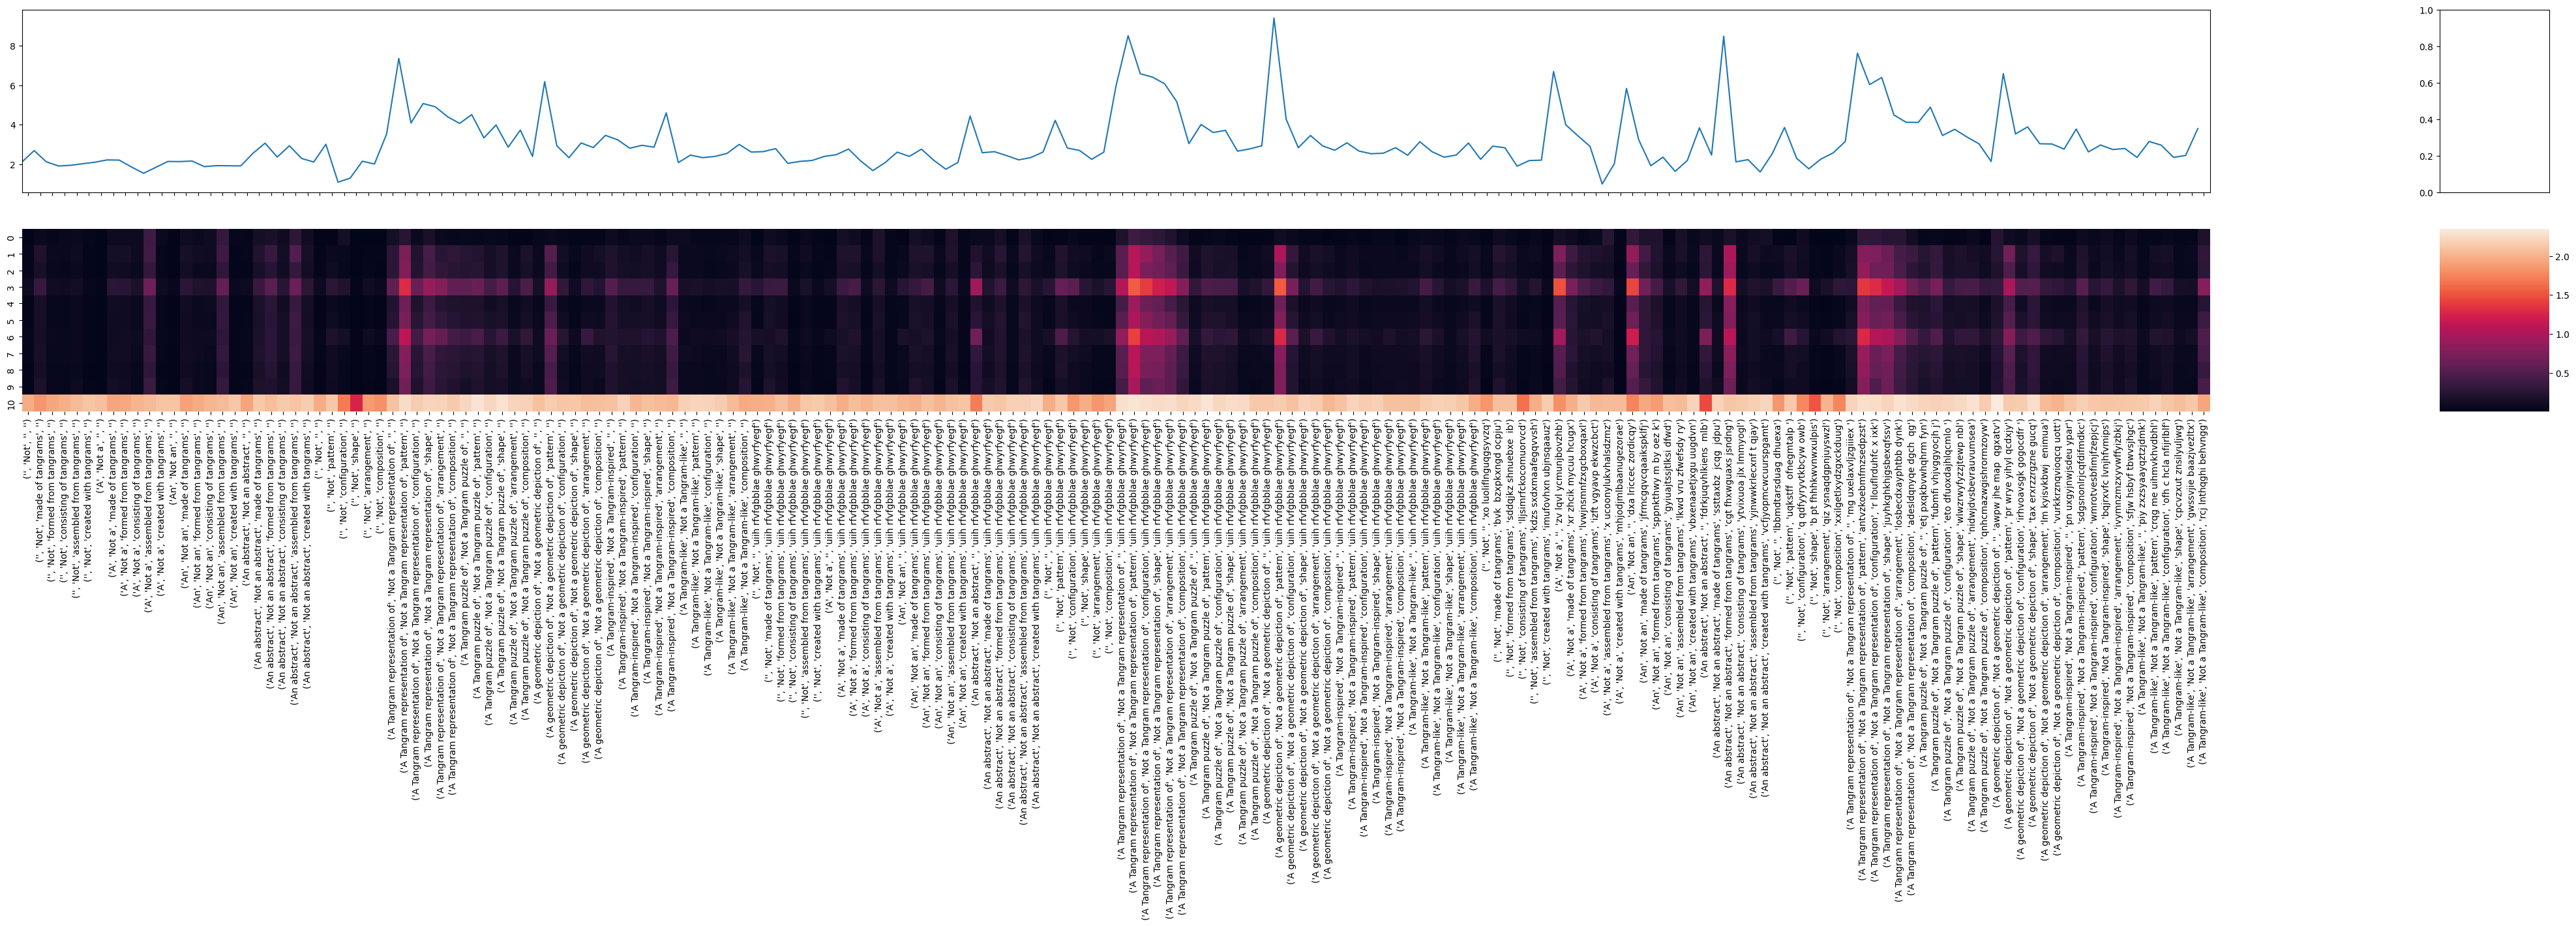

In [19]:
logits_per_text_list_per_image = []
for text_features in text_features_list:
    logits_per_text_list_per_image.append(model.logit_scale.exp() * image_features @ text_features.T)
logits_per_text_list_per_image = torch.stack(logits_per_text_list_per_image)
results = np.array((logits_per_text_list_per_image / model_temperature).softmax(dim=-1).cpu().numpy())
entropies = -(results * np.log(results)).sum(axis=-1).T
_, axs = plt.subplots(2, 2, figsize=(50, 8), sharex='col', gridspec_kw={'width_ratios': [100, 5]})
performance = entropies[1:len(pictures)].sum(axis=0) - 10 * entropies[0]
axs[0, 0].plot(performance)
sns.heatmap(entropies[:len(pictures)], xticklabels=ps_list, ax=axs[1, 0], cbar_ax=axs[1, 1])

180

In [13]:
logits_per_text_list_per_image = []
for text_features in text_features_list:
    logits_per_text_list_per_image.append(model.logit_scale.exp() * (image_features - beta * baseline_features) @ text_features.T)
logits_per_text_list_per_image = torch.stack(logits_per_text_list_per_image)

In [14]:
results = np.array((logits_per_text_list_per_image / model_temperature).softmax(dim=-1).cpu().numpy())
entropies = -(results * np.log(results)).sum(axis=-1).T

In [15]:
def update_heatmap(temperature):
    results = np.array((logits_per_text_list_per_image / float(temperature)).softmax(dim=-1).cpu().numpy())
    entropies = -(results * np.log(results)).sum(axis=-1).T

    _, axs = plt.subplots(2, 2, figsize=(50, 8), sharex='col', gridspec_kw={'width_ratios': [100, 5]})
    axs[0, 0].plot(entropies[1:len(pictures)].sum(axis=0) - 10 * entropies[0])
    axs[0, 0].set_ylim(0, 10)
    sns.heatmap(entropies[:len(pictures)], xticklabels=ps_list, ax=axs[1, 0], cbar_ax=axs[1, 1])

interact(update_heatmap, temperature=widgets.IntSlider(value=model_temperature, min=1));

interactive(children=(IntSlider(value=1, description='temperature', min=1), Output()), _dom_classes=('widget-i…

> Best label "Tangram representation of <> pattern"

In [16]:
def update_heatmap(id):
    fig = plt.subplots(figsize=(50, 4))
    grid = plt.GridSpec(1, 100, fig)
    axs = [plt.subplot(grid[0, :10]), plt.subplot(grid[0, 10:])]
    axs[0].imshow(images[id])
    axs[0].set_axis_off()
    sns.heatmap(entropies[id::len(pictures)], yticklabels=operations, ax=axs[1])
    # plt.tight_layout()

interact(update_heatmap, id=widgets.IntSlider(max=len(pictures)-1));

interactive(children=(IntSlider(value=0, description='id', max=10), Output()), _dom_classes=('widget-interact'…

> Best operation - "shear"

<AxesSubplot: >

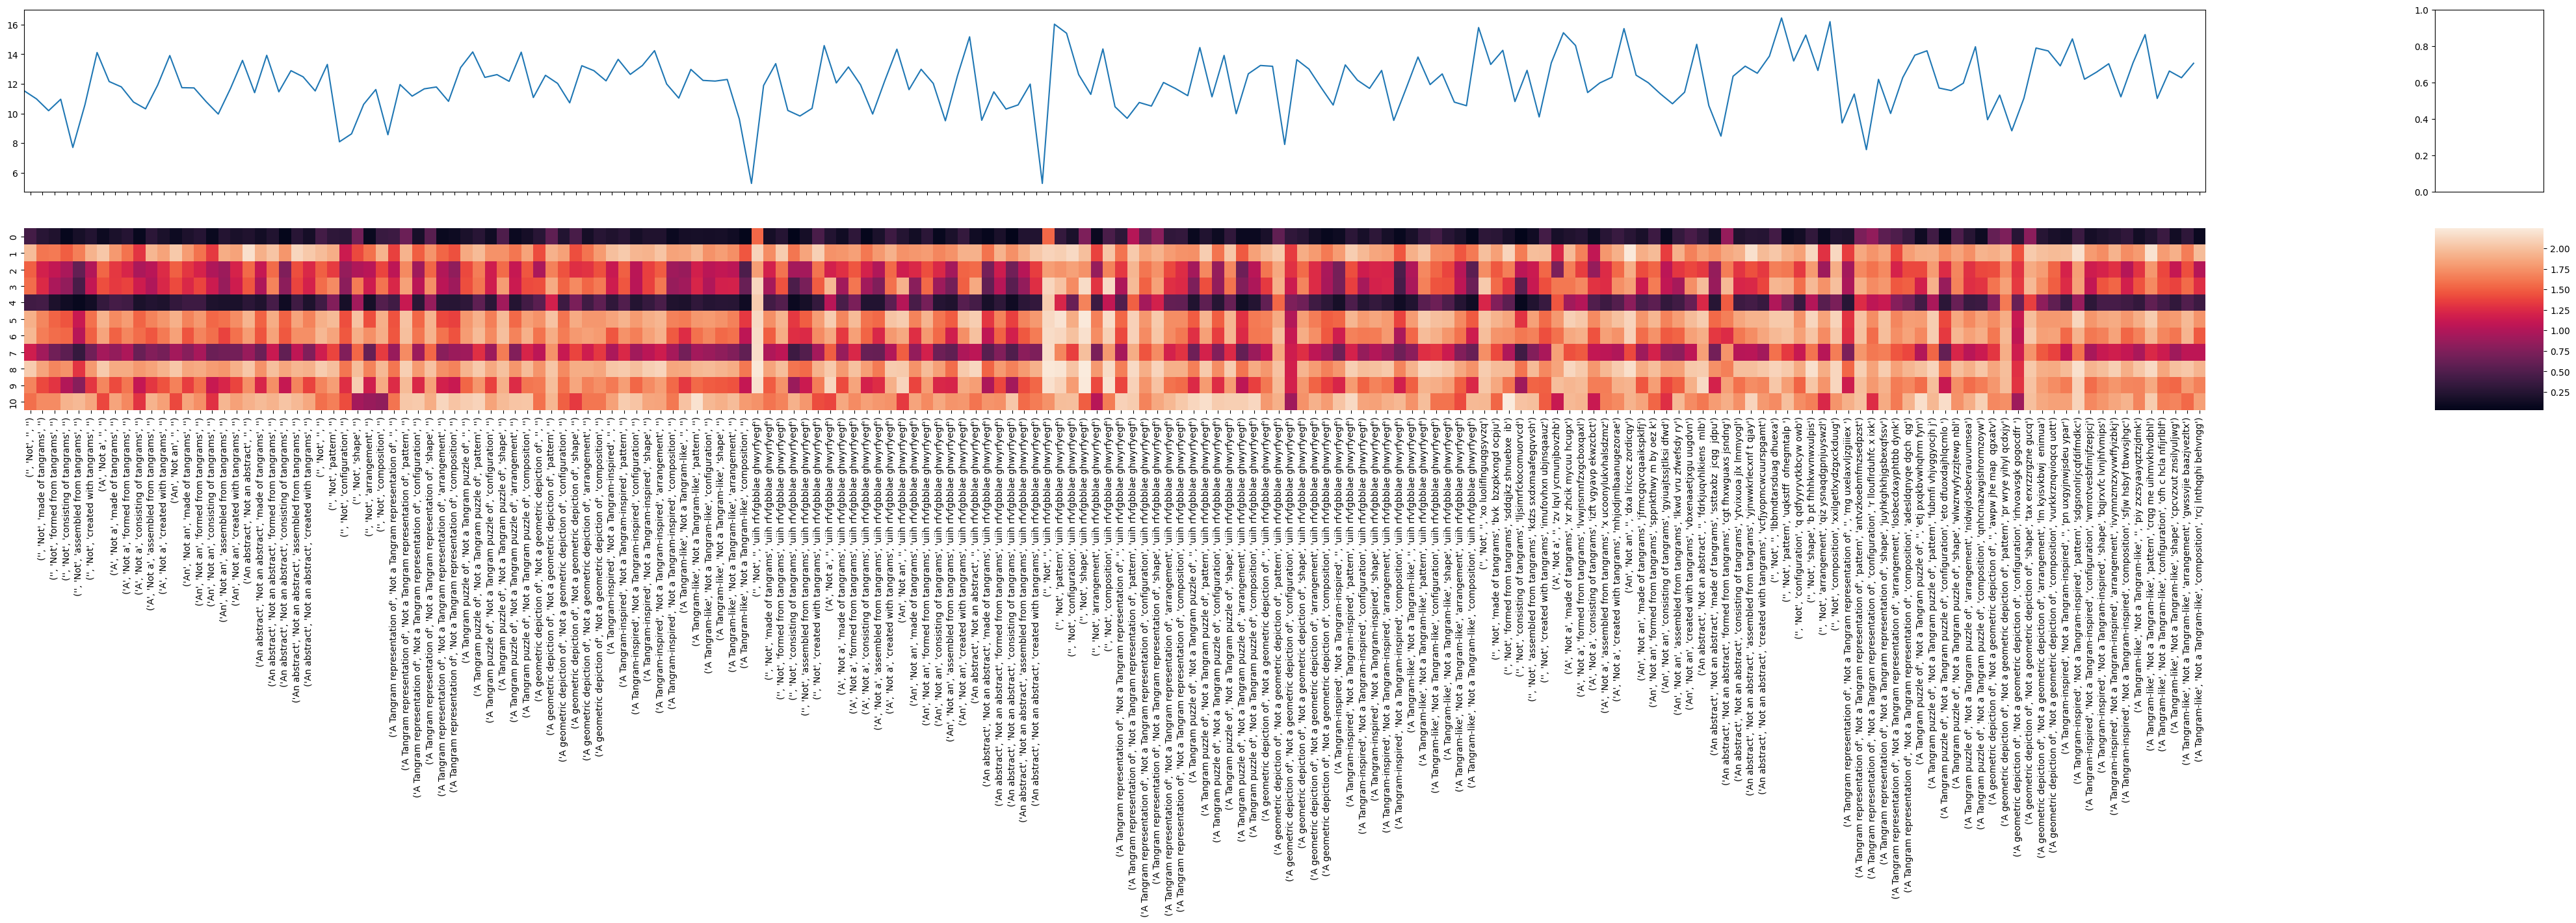

In [17]:
_, axs = plt.subplots(2, 2, figsize=(50, 8), sharex='col', gridspec_kw={'width_ratios': [100, 5]})
axs[0, 0].plot(entropies[-len(pictures) + 1:].sum(axis=0) - 10 * entropies[-len(pictures)])
sns.heatmap(entropies[-len(pictures):], xticklabels=ps_list, ax=axs[1, 0], cbar_ax=axs[1, 1])

In [18]:
def update_heatmap(id):
    fig = plt.subplots(figsize=(50, 4))
    grid = plt.GridSpec(1, 100, fig)
    axs = [plt.subplot(grid[0, :10]), plt.subplot(grid[0, 10:])]
    axs[0].imshow(images[id])
    axs[0].set_axis_off()
    sns.heatmap(results[:, id, :].T, yticklabels=categories, ax=axs[1])
    # plt.tight_layout()

interact(update_heatmap, id=widgets.IntSlider(max=len(images)-1));

interactive(children=(IntSlider(value=0, description='id', max=54), Output()), _dom_classes=('widget-interact'…